In [ ]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

import random

tf.random.set_seed(42)

In [ ]:
'''
userId             -0.009756
Unnamed: 0         -0.008391
cal_consume        -0.007486
isi                 0.014037
active_cal          0.028422
stairs              0.034090
age                 0.034273
month               0.036923
active_ratio        0.053552
distance            0.061890
walks               0.066421
'''

In [ ]:
df_drop = pd.read_csv('df_drop_v2.csv', parse_dates = ['date'], index_col = 'date')
df = df_drop.copy()
df.drop(['Unnamed: 0','cal_consume','isi','active_cal','stairs','age','active_ratio','distance','walks'], axis=1, inplace=True)
df.head()

,userId,bmi,sleep_start_time,sleep_end_time,sleep_min,sleep_efficiency,awaken_min,awaken_moments,nap_total_freq,nap_total_time
date,,,,,,,,,,
2018-04-23,1,16.2,1617.0,1852.0,216.0,0.9191,19.0,21.0,1.0,104.0
2018-04-24,1,16.2,1833.0,2170.0,287.0,0.8516,50.0,20.0,1.0,139.0
2018-04-25,1,16.2,1526.0,2003.0,413.0,0.8658,64.0,28.0,0.0,0.0
2018-04-26,1,16.2,1593.0,1941.0,293.0,0.8420,55.0,26.0,0.0,0.0
2018-04-27,1,16.2,1532.0,1912.0,329.0,0.8658,51.0,27.0,0.0,0.0


In [ ]:
grouped = df.groupby('userId')
train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()
for name, group in grouped:
    print(name)
    print(group)
    if name == 1 or name == 3:
      val_df = pd.concat([val_df,group])
    elif name == 12:
      test_df = pd.concat([test_df,group])
    else:
      train_df = pd.concat([train_df,group])

1
            userId   bmi  ...  nap_total_freq  nap_total_time
date                      ...                                
2018-04-23       1  16.2  ...             1.0           104.0
2018-04-24       1  16.2  ...             1.0           139.0
2018-04-25       1  16.2  ...             0.0             0.0
2018-04-26       1  16.2  ...             0.0             0.0
2018-04-27       1  16.2  ...             0.0             0.0
2018-04-28       1  16.2  ...             0.0             0.0
2018-04-29       1  16.2  ...             1.0            62.0
2018-04-30       1  16.2  ...             0.0             0.0
2018-05-01       1  16.2  ...             0.0             0.0
2018-05-02       1  16.2  ...             0.0             0.0
2018-05-03       1  16.2  ...             1.0           101.0
2018-05-04       1  16.2  ...             0.0             0.0
2018-05-05       1  16.2  ...             0.0             0.0
2018-05-06       1  16.2  ...             0.0             0.0
2018-0

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((1560, 10), (78, 10), (38, 10))

In [ ]:
test_df.head()

,userId,bmi,sleep_start_time,sleep_end_time,sleep_min,sleep_efficiency,awaken_min,awaken_moments,nap_total_freq,nap_total_time
date,,,,,,,,,,
2018-04-23,12,21.72,1923.0,2205.0,239.0,0.8475,43.0,20.0,1.0,138.0
2018-04-24,12,21.72,1614.0,1963.0,293.0,0.8395,56.0,18.0,0.0,0.0
2018-04-25,12,21.72,1878.0,2062.0,161.0,0.8750,23.0,17.0,1.0,151.0
2018-04-26,12,21.72,1690.0,1957.0,235.0,0.8801,32.0,21.0,2.0,162.0
2018-04-27,12,21.72,1784.0,2224.0,388.0,0.8818,52.0,27.0,1.0,97.0


In [ ]:
X_train = train_df.drop(['userId'], axis = 1)
y_train = train_df.loc[:,['sleep_min']]

X_val = val_df.drop(['userId'], axis = 1)
y_val = val_df.loc[:,['sleep_min']]

X_test = test_df.drop(['userId'], axis = 1)
y_test = test_df.loc[:,['sleep_min']]

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1560, 9), (1560, 1), (78, 9), (78, 1), (38, 9), (38, 1))

In [ ]:
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

train_x_norm = input_scaler.transform(X_train)
train_y_norm = output_scaler.transform(y_train)

val_x_norm = input_scaler.transform(X_val)
val_y_norm = output_scaler.transform(y_val)

test_x_norm = input_scaler.transform(X_test)
test_y_norm = output_scaler.transform(y_test)

In [ ]:
val_x_norm[0]

array([-0.11101695,  0.62859145,  0.40509915,  0.24874372,  0.8976856 ,
        0.0492228 ,  0.31343284,  0.5       ,  0.26943005])

In [ ]:
test_y_norm.shape

(38, 1)

In [ ]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []

    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 21

X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_val, y_val = create_dataset(val_x_norm, val_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_val.shape: ', X_val.shape) 
print('y_val.shape: ', y_val.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1539, 21, 9)
y_train.shape:  (1539, 1)
X_val.shape:  (57, 21, 9)
y_val.shape:  (57, 1)
X_test.shape:  (17, 21, 9)
y_test.shape:  (17, 1)


In [ ]:
y_train = np.expand_dims(y_train, axis=1)
y_val = np.expand_dims(y_val, axis=1)
y_test = np.expand_dims(y_test, axis=1)

In [ ]:
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) 
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2)) 
    model.add(Dense(units = 1))
    model.compile(loss='mae', optimizer='adam')
    return model


def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    model.compile(loss='mae', optimizer='adam')
    return model



model_bilstm = create_model_bilstm(42)

model_gru = create_model(42, GRU)
model_lstm = create_model(42, LSTM)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 20)

    history = model.fit(X_train, y_train, epochs = 1000, validation_data=(X_val,y_val),
                    batch_size = 128, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/1000
13/13 [==============================] - 8s 149ms/step - loss: 0.1557 - val_loss: 0.0897
Epoch 2/1000
13/13 [==============================] - 0s 29ms/step - loss: 0.1192 - val_loss: 0.1253
Epoch 3/1000
13/13 [==============================] - 0s 29ms/step - loss: 0.1238 - val_loss: 0.0784
Epoch 4/1000
13/13 [==============================] - 0s 30ms/step - loss: 0.1165 - val_loss: 0.0815
Epoch 5/1000
13/13 [==============================] - 0s 29ms/step - loss: 0.1150 - val_loss: 0.0849
Epoch 6/1000
13/13 [==============================] - 0s 29ms/step - loss: 0.1159 - val_loss: 0.0843
Epoch 7/1000
13/13 [==============================] - 0s 28ms/step - loss: 0.1170 - val_loss: 0.0721
Epoch 8/1000
13/13 [==============================] - 0s 28ms/step - loss: 0.1132 - val_loss: 0.0784
Epoch 9/1000
13/13 [==============================] - 0s 28ms/step - loss: 0.1132 - val_loss: 0.0972
Epoch 10/1000
13/13 [==============================] - 0s 29ms/step - loss: 0.1167 - val_l

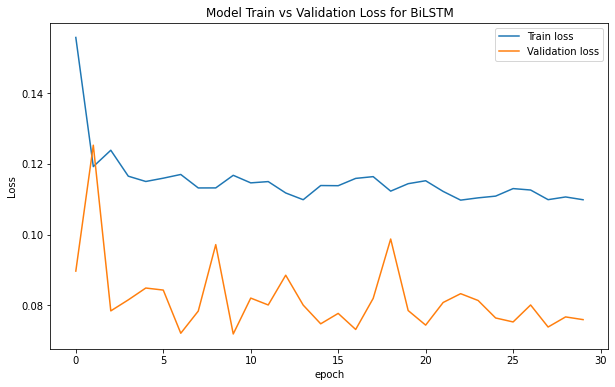

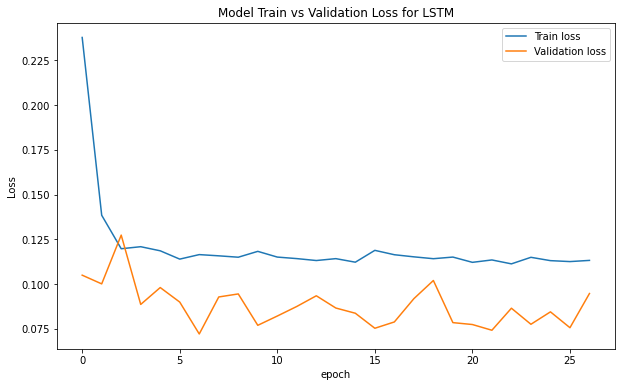

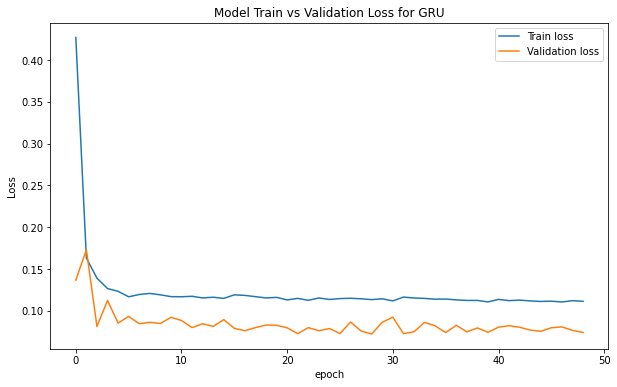

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    

plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [ ]:
y_test.shape

(17, 1, 1)

In [ ]:
y_test = scaler_y.inverse_transform(y_test.reshape(y_test.shape[0],-1))
y_val = scaler_y.inverse_transform(y_val.reshape(y_val.shape[0],-1))
y_train = scaler_y.inverse_transform(y_train.reshape(y_train.shape[0],-1))

In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

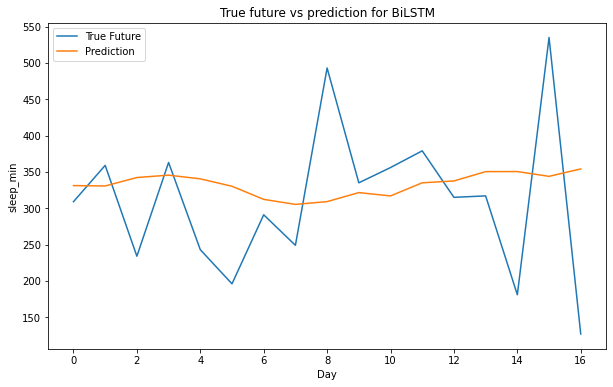

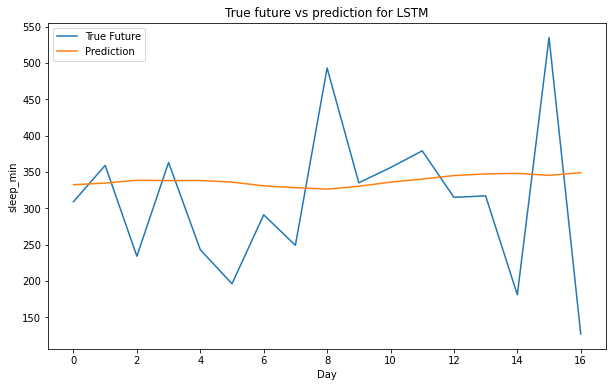

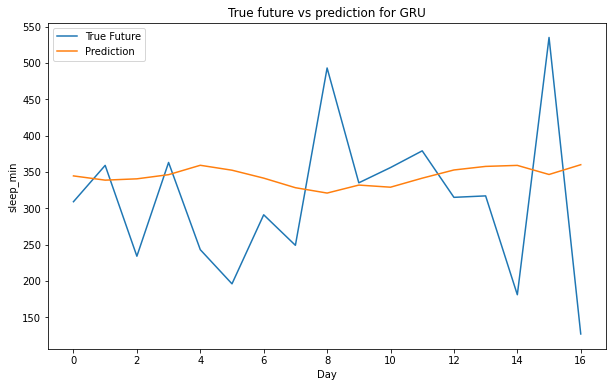

In [ ]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('sleep_min')
    
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.metrics import mean_absolute_percentage_error

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    mape = tf.math.reduce_mean(mean_absolute_percentage_error(y_true=actual, y_pred=predictions))

    print(model_name + ':')
    print('Mean Absolute Error:', mae)
    print('R2 Score:', r2)
    print('Mean Absolute Percentage Error:', mape)


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 82.91547348920037
R2 Score: -0.14916638776318125
Mean Absolute Percentage Error: tf.Tensor(34.968056, shape=(), dtype=float32)
LSTM:
Mean Absolute Error: 82.40002261891084
R2 Score: -0.11207422197568362
Mean Absolute Percentage Error: tf.Tensor(34.98173, shape=(), dtype=float32)
GRU:
Mean Absolute Error: 88.16643389533547
R2 Score: -0.24085714317222728
Mean Absolute Percentage Error: tf.Tensor(37.5935, shape=(), dtype=float32)


In [ ]:
model_bilstm.save('best-bilstm.h5')
model_lstm.save('best-lstm.h5')
model_gru.save('best-gru.h5')

### Charts

In [ ]:
Algo = ['Dense Neural Network', 'Bidirectional LSTM', 'LSTM', 'GRU']
R2_score = [0.13242946994417237, -0.14916638776318125, -0.11207422197568362, -0.24085714317222728]
MAE = [61.98444356416401, 82.91547348920037, 82.40002261891084, 88.16643389533547]
MAPE = [22.198084, 34.968056, 34.98173, 37.5935]

In [ ]:
Comparison = pd.DataFrame(list(zip(Algo, R2_score, MAE, MAPE)), columns = ['Algorithm', 'R2 Score', 'MAE', 'MAPE'])
Comparison.head()

,Algorithm,R2 Score,MAE,MAPE
0,Dense Neural Network,0.132429,61.984444,22.198084
1,Bidirectional LSTM,-0.149166,82.915473,34.968056
2,LSTM,-0.112074,82.400023,34.981730
3,GRU,-0.240857,88.166434,37.593500


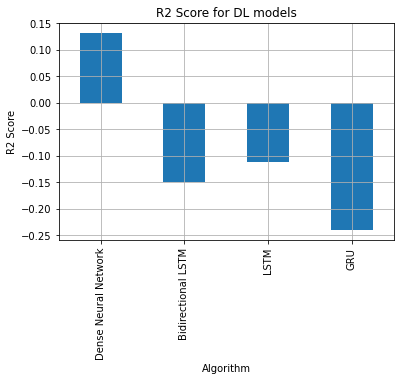

In [ ]:
# R2 Score

ax = Comparison['R2 Score'].plot(kind="bar")
ax.set_title("R2 Score for DL models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("R2 Score")
ax.set_xticklabels(Comparison['Algorithm'])

plt.grid()
plt.show()

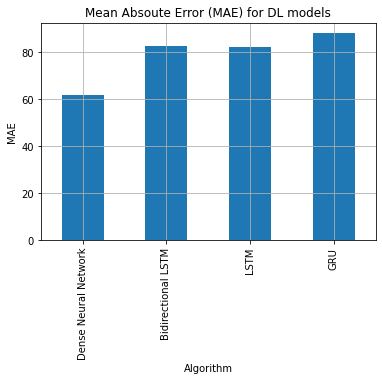

In [ ]:
# MAE

ax = Comparison['MAE'].plot(kind="bar")
ax.set_title("Mean Absoute Error (MAE) for DL models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("MAE")
ax.set_xticklabels(Comparison['Algorithm'])

plt.grid()
plt.show()

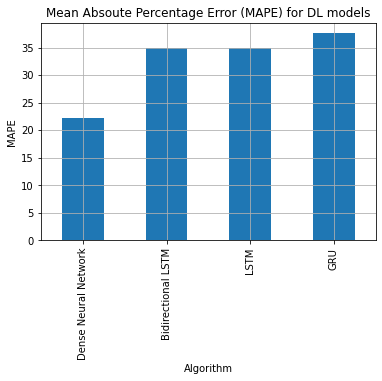

In [ ]:
# MAPE

ax = Comparison['MAPE'].plot(kind="bar")
ax.set_title("Mean Absoute Percentage Error (MAPE) for DL models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("MAPE")
ax.set_xticklabels(Comparison['Algorithm'])

plt.grid()
plt.show()

### Comparing ML and DL models

In [ ]:
Algo = ['Random Forest Regression', 'Linear Support Vector Regression', 'Dense Neural Network', 'LSTM']
R2_score = [0.12376322345533608, 0.10108749883398183, 0.3397321366829993, -0.11207422197568362]
MAE = [67.23822371622259, 67.41804962249621, 62.842124285016745, 82.40002261891084]
MAPE = [25.165808789698314, 25.64410671405831, 27.237825, 34.98173]

In [ ]:
Comparison = pd.DataFrame(list(zip(Algo, R2_score, MAE, MAPE)), columns = ['Algorithm', 'R2 Score', 'MAE', 'MAPE'])
Comparison.head()

,Algorithm,R2 Score,MAE,MAPE
0,Random Forest Regression,0.123763,67.238224,25.165809
1,Linear Support Vector Regression,0.101087,67.418050,25.644107
2,Dense Neural Network,0.339732,62.842124,27.237825
3,LSTM,-0.112074,82.400023,34.981730


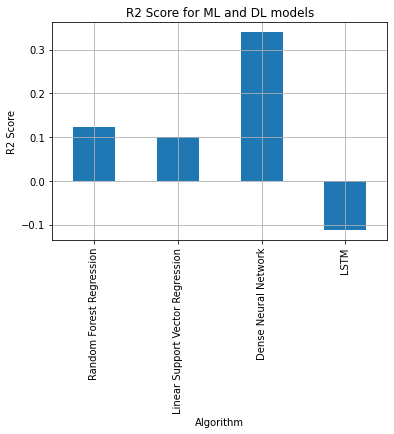

In [ ]:
# R2 Score

ax = Comparison['R2 Score'].plot(kind="bar")
ax.set_title("R2 Score for ML and DL models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("R2 Score")
ax.set_xticklabels(Comparison['Algorithm'])

plt.grid()
plt.show()

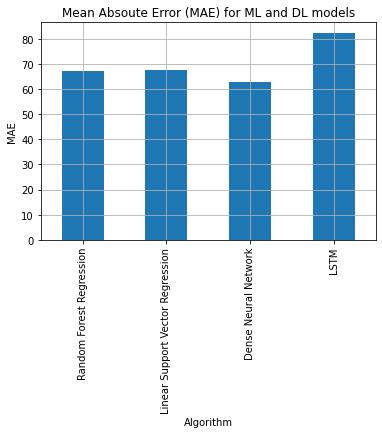

In [ ]:
# MAE

ax = Comparison['MAE'].plot(kind="bar")
ax.set_title("Mean Absoute Error (MAE) for ML and DL models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("MAE")
ax.set_xticklabels(Comparison['Algorithm'])

plt.grid()
plt.show()

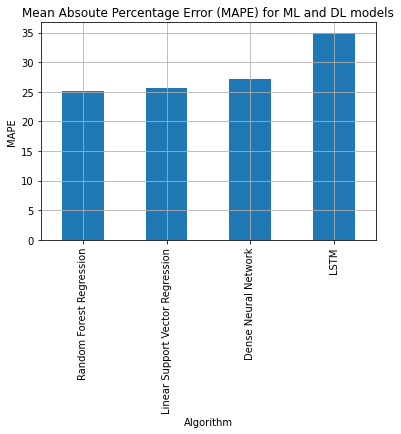

In [ ]:
# MAPE

ax = Comparison['MAPE'].plot(kind="bar")
ax.set_title("Mean Absoute Percentage Error (MAPE) for ML and DL models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("MAPE")
ax.set_xticklabels(Comparison['Algorithm'])

plt.grid()
plt.show()